# Introduction

This notebook is meant for beginners in Data Science / Analysis. I am a beginner myself and was happy to get the advise of an friend to start with the IRIS data set for analyzing and visualizing data. You will find some steps marked as "For curiosity only". Those steps could be skipped, if you just want to find a model that can predict the correct categories. But as a beginner I thought it is a good opportunity to also try out some additional coding and methods to get some experiences and understanding in data analyis.

# Import Modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import StandardScaler

# Data import and summary analysis

Import dataset from csv into Pandas DataFrame for analysis.

In [2]:
iris = pd.read_csv("Iris.csv")

Display first five rows to review layout of dataset.

In [3]:
iris.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


---  
**Findings:**  
 - "Id" column is assigning a unique number to each record. Obsolete for further processing.  
 -"SepalLengthCm", "SepalWidthCm", "PetalLengthCm" and "PetalWidthCm" represent the features (variables) of the set. They provide the measured length and width of the Sepals and Petals.  
 -"Species" provides the target category per record. This will be used for supervised learning of the model and will be the prediction target of the model.  
 ---

Drop column "Id" as it is redundant with Index.

In [4]:
iris.drop("Id", axis=1, inplace=True)

Check data types of columns automatically assigned by pandas during import.

In [5]:
iris.dtypes

SepalLengthCm    float64
SepalWidthCm     float64
PetalLengthCm    float64
PetalWidthCm     float64
Species           object
dtype: object

All columns have been imported with the correct datatype. No corrections required.  
  
Create high-level statistical summary of numeric variables.

In [6]:
iris.describe()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


---  
**Findings:**  
 - Sepals are in general larger than Petals.  
 - Length of Petals have the largest variation of the variables (indicated by std and absolute difference between lowest and highest quartile)  
---  
  
Check the number of null-values per column.

In [7]:
iris.isnull().sum()

SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

# Visual Data Analysis

Create correlation matrix for features to understand dependency between features.

In [8]:
iris.corr()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
SepalLengthCm,1.000000,-0.109369,0.871754,0.817954
SepalWidthCm,-0.109369,1.000000,-0.420516,-0.356544
PetalLengthCm,0.871754,-0.420516,1.000000,0.962757
PetalWidthCm,0.817954,-0.356544,0.962757,1.000000


Plot basic correlation matrix with Matplotlib.

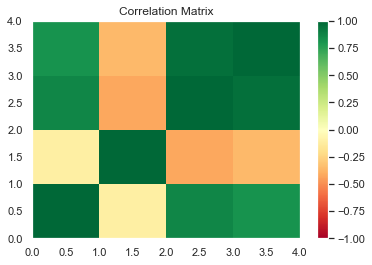

In [9]:
sns.set()
plt.pcolor(iris.corr(), cmap="RdYlGn", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.colorbar()
plt.show()

Plot correlation matrix with seaborn without finetuning the formatting. Compare formatting of matrix to the matplotlib version. Seaborn is out of the box formatted more suitable for the viewer.

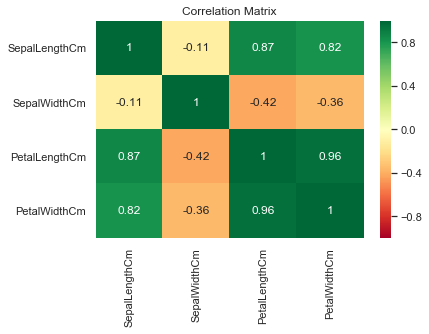

In [10]:
sns.heatmap(iris.corr(), vmin=-1, vmax=1, cmap="RdYlGn", annot=True)
plt.title("Correlation Matrix");

**For demonstration only:**  
Calculate Pearson Correlation Coefficient with corresponding P-Value.

In [11]:
Pearson_coef, p_value = stats.pearsonr(iris["PetalLengthCm"],iris["SepalLengthCm"])
print(f"Correlation: {Pearson_coef}")
print(f"P-Value: {p_value}")

Correlation: 0.8717541573048713
P-Value: 1.0384540627941062e-47


---
**Findings:**  
 - P-Value below 0.01 confirms statistical significance of correlation between "PetalLenghtCm" and "SepalLengthCm"  
---

For visual analysis of data distribution and correlation, print a grid of scatter plots and line histograms of of feature vs. feature.

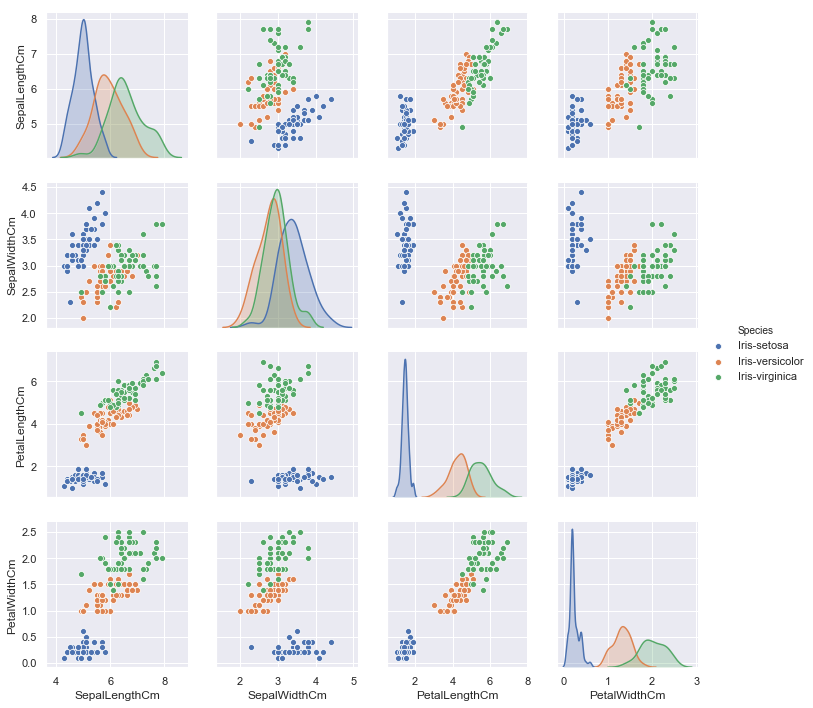

In [12]:
sns.pairplot(iris, kind="scatter", hue="Species");

---
**Findings:**  
 - As already stated above, length and width of Petals have a strong linear correlation.
 - "SepalLengthCm" and "PetalLenghtCm" correlate linear for Iris-versicolor and -virginica.
 - "Iris-setosa" separates on lenght and width of Petals from the other two species.
---

**For Curiosity only:**  
Just another test for one plot in larger size

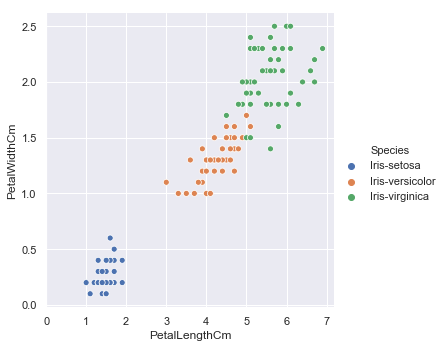

In [13]:
sns.set()
sns.relplot(x="PetalLengthCm", y="PetalWidthCm", hue="Species", data=iris)
plt.xlim(0,);

# Modeling and Evaluation

Split prediction target (Y) and feature data (X)

In [14]:
y = iris["Species"]
X = iris.drop("Species", axis=1)

## Model Evaluation

Define the models to be used.

In [28]:
mnb = MultinomialNB()
gnb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=3)

models = [mnb, gnb, knn]

Split Train and Test Data with fixed seed (9) to ensure same random data is picked every time. If data would be randomized each time, changes to the data or model could not be evaluated, as results change due to different training and test data.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=9, test_size=.25)

Initialize models and get prediction score per model.

In [24]:
def model_evaluation(model, name, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    wrong_absolute = len(y_test) - sum(y_test == y_predicted)
    print(f"{name}: {model.score(X_test, y_test)} (Wrong: {wrong_absolute})")

for model in models:
    model_evaluation(model, model.__class__.__name__, X_train, y_train, X_test, y_test)

MultinomialNB: 0.868421052631579 (Wrong: 5)
GaussianNB: 1.0 (Wrong: 0)
KNeighborsClassifier: 1.0 (Wrong: 0)


---
**Findings:**  
 - GaussianNB and KNeighborsClassifier perform with 100% prediction quality.
 - MultinomialNB performs better with categorical features. So it was expected that Gaussian Naive Bayes performes better, as the features are metrics.  
---  

## Evaluate robustness of models based on variation of train and test data

### Manual (self-programmed) approach

Due to the very small data size, check if the random train and test data variation has an impact on the prediction results (should not be relevant for large data sizes).

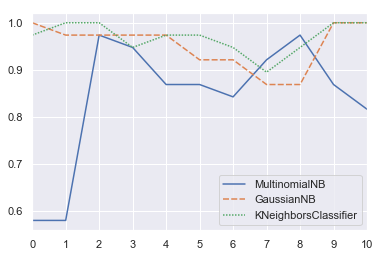

In [25]:
def sampling(models, X_samp, y_samp, randoms):
    results_dict = {}
    for model in models:
        results = []
        for random in range(0, (randoms+1)):
            X_train_samp, X_test_samp, y_train_samp, y_test_samp = train_test_split(X_samp, y_samp, random_state=random, test_size=.25)
            model.fit(X_train_samp, y_train_samp)
            results.append(model.score(X_test_samp, y_test_samp))
        results_dict[model.__class__.__name__] = results
    return results_dict

randoms = 10
results_random = sampling(models, X, y, randoms)
random_df = pd.DataFrame(results_random)
sns.lineplot(data=random_df)
plt.xlim(0,10)
plt.xticks([i for i in range(0, (randoms+1))]);

### Out-of-the-box approach with scikit-learn cross-validation function

In [26]:
def model_cross_eval(model, name, X, y):
    scores = cross_val_score(model, X, y, cv=5)
    av_score = np.mean(scores)
    av_wrong = round((1-av_score) * len(y))
    print(f"{name}: {av_score} (Av. wrong: {int(av_wrong)})")

for model in models:
    model_cross_eval(model, model.__class__.__name__, X, y)

MultinomialNB: 0.9533333333333334 (Av. wrong: 7)
GaussianNB: 0.9533333333333334 (Av. wrong: 7)
KNeighborsClassifier: 0.9800000000000001 (Av. wrong: 3)


## Tuning of hyperparameter "n_neighbors" for KNeighborsClassifier

### Manual (self-programmed) approach

KNeighborsClassifier is the most reliable model for the data. Further analyze the impact of hyperparameter n_neighbors on prediction quality (with random_state seed 9).

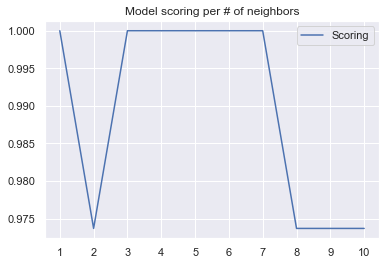

In [27]:
neighbors = 10
results_dict = {}
for n in range(1, (neighbors+1)):
    model = KNeighborsClassifier(n_neighbors=n)
    model.fit(X_train, y_train)
    results_dict[n] = model.score(X_test, y_test)

sns.set()
knn_df = pd.DataFrame(index=results_dict.keys(), data=results_dict.values())
knn_df.rename(columns={0:"Scoring"}, inplace=True)
sns.lineplot(data=knn_df, markevery=1)
plt.title("Model scoring per # of neighbors")
plt.xticks([i for i in range(1, (neighbors+1))]);

---
**Findings:**  
 - Optimal value for parameter n_neighbors is between 3 and 7
 - Although 1 delivers in the tested setup 1.0 accuracy, without further analyzing it can be assumed to be highly volatile, as it might deliver different results with a slight change in the train and test data
---

### Out-of-the-box approach with scikit-learn grid search function

In [41]:
parameter = [{"n_neighbors": [1,2,3,4,5,6,7,8,9,10]}]

knn_grid = GridSearchCV(knn, parameter, cv=5)
knn_grid.fit(X, y)
knn_grid.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')

In [47]:
scores = knn_grid.cv_results_
scores_df = pd.DataFrame(index=scores["params"], data=scores["mean_test_score"])
scores_df.rename(columns={0:"mean_test_score"}, inplace=True)
scores_df

,mean_test_score
{'n_neighbors': 1},0.960000
{'n_neighbors': 2},0.946667
{'n_neighbors': 3},0.966667
{'n_neighbors': 4},0.973333
{'n_neighbors': 5},0.973333
{'n_neighbors': 6},0.980000
{'n_neighbors': 7},0.980000
{'n_neighbors': 8},0.966667
{'n_neighbors': 9},0.973333
{'n_neighbors': 10},0.980000


---
**Findings:**  
 - Optimal value for parameter n_neighbors is 6, 7 or 10
 - Other than assumed before, 1 performs better than 2 as parameter value
---

In [44]:
scores_new_df = pd.DataFrame(scores)
scores_new_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001396,4.887724e-04,0.001999,9.146826e-06,1,{'n_neighbors': 1},0.966667,0.966667,0.933333,0.933333,1.0,0.960000,0.024944,9
1,0.001208,4.055423e-04,0.001984,1.124507e-05,2,{'n_neighbors': 2},0.966667,0.933333,0.933333,0.900000,1.0,0.946667,0.033993,10
2,0.001192,3.903156e-04,0.001796,3.995911e-04,3,{'n_neighbors': 3},0.966667,0.966667,0.933333,0.966667,1.0,0.966667,0.021082,7
3,0.001397,4.878396e-04,0.001397,4.873341e-04,4,{'n_neighbors': 4},0.966667,0.966667,0.966667,0.966667,1.0,0.973333,0.013333,4
4,0.001397,4.876849e-04,0.001196,3.992840e-04,5,{'n_neighbors': 5},0.966667,1.000000,0.933333,0.966667,1.0,0.973333,0.024944,4
5,0.000994,1.003241e-05,0.001399,4.836849e-04,6,{'n_neighbors': 6},0.966667,1.000000,0.966667,0.966667,1.0,0.980000,0.016330,1
6,0.001396,4.891618e-04,0.001196,3.989232e-04,7,{'n_neighbors': 7},0.966667,1.000000,0.966667,0.966667,1.0,0.980000,0.016330,1
7,0.000997,3.814697e-07,0.001996,6.217196e-07,8,{'n_neighbors': 8},0.966667,1.000000,0.933333,0.933333,1.0,0.966667,0.029814,7
8,0.000997,1.070497e-06,0.001596,4.885214e-04,9,{'n_neighbors': 9},0.966667,1.000000,0.966667,0.933333,1.0,0.973333,0.024944,4
9,0.001197,4.014284e-04,0.000996,2.461145e-06,10,{'n_neighbors': 10},0.966667,1.000000,1.000000,0.933333,1.0,0.980000,0.026667,1


# For curiousity only: Multinomial Naive Bayes testing
Analyze the prediction quality of Multinomial Naive Bayes model by reducing the number of features to two.

In [ ]:
columns_count = len(X_train.columns)
for i in range(0, (columns_count-1)):
    for j in range((i+1), columns_count):
        column1 = X_train.columns[i]
        column2 = X_train.columns[j]
        model_evaluation(
            mnb,
            str(column1.ljust(16) + column2.ljust(16)),
            X_train[[column1, column2]],
            y_train,
            X_test[[column1, column2]],
            y_test
        )

---  
**Findings:**  
 - Combination of "SepalLengthCm" with "PetalWidthCm" only 0.05 below prediction score, when all features are used.
 - Best prediction result, when considering all features.
---  

Create confusion matrix to analyze where the misclassifications happens for best performing combination.

In [ ]:
features_mnb = ["SepalLengthCm", "PetalWidthCm"]
X_train_reduced = X_train[features_mnb]
X_test_reduced = X_test[features_mnb]
mnb.fit(X_train_reduced, y_train)
y_predicted = mnb.predict(X_test_reduced)

classes = unique_labels(y_test, y_predicted)
cm = confusion_matrix(y_test, y_predicted, labels=classes)
df_cm = pd.DataFrame(columns=classes, index=classes, data=cm)

sns.heatmap(df_cm, annot=True, cbar=False, cmap="Blues")
plt.yticks(rotation=0)
plt.title("Confussion Matrix");

# For Curiosity only: Use Data for a regression model

Use the two dimensions "PetalLengthCm" and "PetalWidthCm" that were visually most linear correlated (see above pairplot).

In [ ]:
features_reg = ["PetalLengthCm", "PetalWidthCm"]
X_reg = iris[features_reg]

In [ ]:
y_reg = X_reg["PetalWidthCm"]
x_reg = X_reg[["PetalLengthCm"]]

reg = LinearRegression()
reg.fit(x_reg, y_reg)
y_reg_predicted = reg.predict(x_reg)
print(f"Intercept: {reg.intercept_}")
print(f"Coefficient: {reg.coef_[0]}")

## Plot linear regression model

Plot the scatter plot with the regression model line and resize the axis to also visually show the slope of the curve - matching the calculated coefficient.

In [ ]:
sns.set()
sns.regplot(x="PetalLengthCm", y="PetalWidthCm", data=iris)
plt.ylim(0,7)
plt.xlim(0,7);

## Plot residuals of true values vs. computed graph

"Zoom" in on the distance of the true data points vs. the calculated regression line.

In [ ]:
sns.set()
sns.residplot(iris["PetalLengthCm"], iris["PetalWidthCm"])
plt.xlim(0,7);

---
**Findings:**  
 - With increasing length of the Petals the accuracy of the model to predict the width of the petals reduces.
---